In [2]:
import os
import import_ipynb
import pandas as pd
import itertools
import talib
import math
import numpy as np
from numpy import nan

'''to be modified and shift into property files'''
currentpath=os.getcwd()
dbpath=os.path.join(currentpath,"..",'database')
stockcsv=os.path.join(dbpath,'stockpath.csv')
stocktest=os.path.join(dbpath,'stocktest.csv')

featurescsv=os.path.join(dbpath,'features.csv')
featuresdata=os.path.join(dbpath,'featuresdata.csv')



#to import Load_Csv file from another directory. this style is for jupyter notebook
                
%cd ..
from utility import Load_Csv as lcsv
%cd stockprediction



C:\Prgs\Code\mokshtech\Fin_Product
C:\Prgs\Code\mokshtech\Fin_Product\stockprediction


In [3]:
class ta(lcsv.Load_csv):
    '''this class contains functions fto predict label with the help of technical indicators'''
    
    def __init__(self,filename=stockcsv):
        self.filename=filename
    

    def loadcsv(self):
        '''load 'Date','Close', 'Volume' data from databse and return dataframe
        '''
        
        self.dataset=self.LoadData(self.filename).loc[:, ['Date','Close', 'Volume','Open']]
        self.dataset['Date'] = pd.to_datetime(self.dataset['Date'])
        return self.dataset
    

    def loadfeaturesdata(self,x):
        '''load features detailed data from databse'''
        self.featuresdata=self.LoadfeaData(featuresdata)
        self.featuresdata.index=self.featuresdata[0]
        #self.featuresdata=self.featuresdata.loc[x]
        return list(self.featuresdata.loc[x,1:])
    
    
    def ti_Combinations(self):
        '''takes input as list of list and  gives output as comninations '''
        
        #print("ti_Combinations")

        self.paneldict={}
        def comb_r(row):
            
            #print(self.dataset)
            #print('row',row)
            comb_dataset=self.dataset.copy(deep=True)
            for i in row:
                #print('i',i)
                comb_dataset['MA'+str(i)]=self.tdf['MA'+str(i)]
                #print('comb_dataset',comb_dataset)
            #print('c',comb_dataset)    #To print dataset with all combinations of MA
            
            #print('self.paneldict',self.paneldict)
            self.paneldict[row]=comb_dataset.copy(deep=True)
            #print('self.paneldict2',self.paneldict)


        try:
            a=self.tidict['MA']
            #print('combinations_input',a)
            #[[10],[50],[60-64]]
            comb_df=pd.Series(list(itertools.product(*a)))##get combinatons 
            #print('comb_df',comb_df)
            comb_df.apply(comb_r)
            panel_dataset=pd.Panel(self.paneldict)
         
            '''
            ### Error: Panel is not working here . 
            On printing panel it is printing merge of all unique columns for each dataframe.
            
            
            #print(item for item in panel_dataset.items])  # to print item name of panel
            #print('(2, 4, 60)',panel_dataset[(2, 4, 60)])
            
            '''
            
            
        except Exception as e:
            print('e2',e)         
       
        
    def loadfeatures(self):
        '''load feature label data from databse
        '''
        self.featurestilist=[]
        self.misc=[]
        self.label=[]
        self.tilist=dir(talib)
        self.featuredict={}
        self.tidict={}
        self.features=self.LoadfeaData(featurescsv)

         
        def func(value,args):
           

            if str(value).find("-")>-1:   #tocheck if range is given 
                a,b=value.split("-")
                a=int(a)
                b=int(b)

                self.featuredict[args].extend(list(range(a,b)))   #if range is given then replace it by list
                self.tidict[args].append(list(range(a,b))) 

            else:
                try:
                    var=str(args)+'-'+str(int(value))              #togenerate name like MA-1,MA-2  

                    self.featuredict[args].extend(self.loadfeaturesdata(var))
                    
                    self.tidict[args].append(self.loadfeaturesdata(var))
                except Exception as e:
                    print('e1',e)    
        
        
        def funr(row):
            r_len=len(row)
            ti=row[0]
            rowdf=pd.Series(row[1:])
            
                     
            if ti in self.tilist:
                self.featuredict[ti]=[]
                self.tidict[ti]=[]
                self.featurestilist.append(ti)
                
                rowdf.apply(func,args=(ti,))    #Vectorize function over each element
                
            elif ti=='label':
                self.label.append(row[1])
            else:
                self.misc.append(row)
    
                
                                                 #vectorize approach to speed up process        
        self.features.apply(funr, axis=1)
        #print(self.featuredict)                  #To be removed after development
        #print(self.features)
        #print("end")
        
        
        
        #return(self.featurestilist,self.label,self.misc,self.MA_comb)
        
        
        
    def get_MA(self,x):
        malist=self.featuredict['MA']
        for i in malist:
            if ('MA'+str(i)) in self.tdf:
                continue
            else:          
                self.tdf['MA'+str(i)]=talib.SMA(self.dataset[x],i)
        return(self.tdf)
        
    def get_RSI(self,x):
        rsilist=self.featuredict['RSI']
        for i in rsilist:
            if ('RSI'+str(i)) in self.tdf:
                continue
            else:
                self.dataset['RSI'+str(i)]=talib.RSI(self.dataset[x],i)
        return(self.dataset)
        
        
        
    def get_technical_indi(self):
        
        self.tdf=self.LoadData(stockcsv).loc[:, ['Close']]
        for i in self.featurestilist:
            if i=='MA':
                self.get_MA('Close')
            if i=='RSI':
                self.get_RSI('Close')
                
                
    def get_return(self):
        self.dataset['Daily_Return'] = self.dataset['Close'].pct_change()
        
        
    def get_label(self):
        print("start technical analysis and  Calculate technical indicators")
        if self.label[0]=='return':
            self.get_return()
        #print(self.dataset)
        #print(self.tdf)
        #print(self.tidict)
       
    def get_panel_data(self,arg):
        self.loadcsv()
        self.loadfeatures()
        self.get_technical_indi()
        self.get_label()
        self.ti_Combinations()
        print(arg)
        return self.paneldict[arg]

        
        
        

In [4]:
b=ta()
train_paneldict=b.get_panel_data((2,4,60))


e1 cannot convert float NaN to integer
start technical analysis and  Calculate technical indicators
(2, 4, 60)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:183: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



In [5]:
test_size=0.2 #b.test_size  #to split dataset in training and testing part.   
LSTM_units=50
LSTM_unit_increment=30
dropoutunit=0.2
layer=4


In [17]:
import matplotlib.pyplot as plt
from datetime import date
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df = train_paneldict.iloc[61:, 2:]
print('df',df)
y = train_paneldict.iloc[61:, 1:2] #Close  # implement method to get label from file.
print(y)
#feature scaling 
sc = MinMaxScaler(feature_range = (0, 1))
df_scaled = sc.fit_transform(df)
y_scaled = sc.fit_transform(y)

#Creating data sctructure for test and training
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y_scaled, test_size=test_size)
X_train, y_train = np.array(X_train), np.array(y_train)


print('Before reshaping','X_train :{0}, y_train :{1} ,X_test :{2} ,y_test :{3}'.format(X_train.shape, y_train.shape,X_test.shape, y_test.shape))

#Reshape xtrain and xtest to fit in lstm model

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#print('After reshaping','X_train :{0}, y_train :{1} ,X_test :{2} ,y_test :{3}'.format(X_train.shape, y_train.shape,X_test.shape, y_test.shape))

#return(X_train, X_test, y_train, y_test)

df          Volume      Open      RSI10      RSI20  Daily_Return        MA2  \
61    145948276   6171.15  60.270257  57.737236      0.006760   6196.975   
62    156852586   6204.25  58.370841  56.869694     -0.002573   6209.850   
63    186169067   6187.95  53.575251  54.659747     -0.006595   6181.400   
64    186060466   6262.45  60.619917  58.024502      0.013009   6201.025   
65    158539890   6234.40  62.118066  58.779786      0.003012   6250.500   
66    198285630   6415.00  69.297429  62.689113      0.016614   6311.900   
67    242412856   6354.70  65.198440  60.874712     -0.004879   6348.375   
68    148196394   6307.20  61.927951  59.420058     -0.003940   6320.375   
69    148533899   6276.75  53.465839  55.458751     -0.011232   6272.475   
70    169650657   6201.30  46.609054  51.927871     -0.011007   6202.725   
71    146451539   6168.35  45.320288  51.242540     -0.002221   6161.550   
72    154174701   6178.20  43.783664  50.442038     -0.002543   6146.875   
73    243

In [7]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))


In [9]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(0.2))

In [10]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 150, return_sequences = True))
regressor.add(Dropout(0.2))


In [11]:
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 200))
regressor.add(Dropout(0.2))

In [12]:
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
print(X_train.shape,y_train.shape)
regressor.fit(X_train, y_train, epochs = 20, batch_size = 200)


(807, 8, 1) (807, 1)
Epoch 1/20
807/807 [==============================] - 5s 6ms/step - loss: 0.2501
Epoch 2/20
807/807 [==============================] - 1s 1ms/step - loss: 0.0702
Epoch 3/20
807/807 [==============================] - 1s 1ms/step - loss: 0.0487
Epoch 4/20
807/807 [==============================] - 1s 1ms/step - loss: 0.0517
Epoch 5/20
807/807 [==============================] - 1s 1ms/step - loss: 0.0400
Epoch 6/20
807/807 [==============================] - 1s 1ms/step - loss: 0.0374
Epoch 7/20
807/807 [==============================] - 1s 1ms/step - loss: 0.0398
Epoch 8/20
807/807 [==============================] - 1s 1ms/step - loss: 0.0343
Epoch 9/20
807/807 [==============================] - 1s 1ms/step - loss: 0.0373
Epoch 10/20
807/807 [==============================] - 1s 2ms/step - loss: 0.0330
Epoch 11/20
807/807 [==============================] - 1s 2ms/step - loss: 0.0292
Epoch 12/20
807/807 [==============================] - 1s 2ms/step - loss: 0.0265
Epoc

In [13]:
# Part 3 - Making the predictions and visualising the results


#real_stock_price = dataset_test.iloc[:, 1:2].values

'''
dataset_total = pd.concat((dataset_train_a['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 133):
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


'''


predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y_test = sc.inverse_transform(y_test)



print('p',predicted_stock_price[0:5])
print('r',y_test[0:5])

predicted_stock_price=predicted_stock_price[0:60]
y_test=y_test[0:60]


p [[8079.712]
 [9914.187]
 [8596.93 ]
 [8345.216]
 [8190.502]]
r [[ 7558.2 ]
 [10451.8 ]
 [10118.05]
 [ 8353.1 ]
 [ 7981.9 ]]


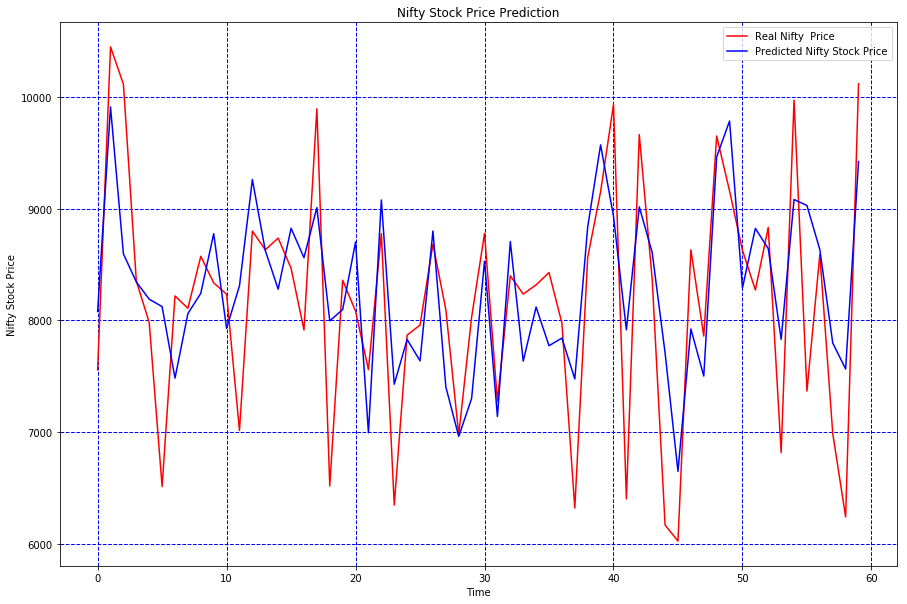

In [14]:
# Visualising the results
width = 15
height = 10
plt.figure(figsize=(width, height))


plt.plot(y_test, color = 'red', label = 'Real Nifty  Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Nifty Stock Price')
plt.title('Nifty Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nifty Stock Price')
plt.legend()
plt.grid(color='b', linestyle='--', linewidth=1)



plt.show()



In [15]:
#print("Score:", regressor.score(X_test, y_test))


In [ ]:
nsepickel1 = open("nsepickel1",'wb')
pickle.dump(regressor , nsepickel1)
nsepickel1.close()